# Funda Sales Forecasting using XGBoost
- Data Preprocessing
  - 거래 내역이 음수인 경우, 최근 거래 내역 중 같은 카드를 사용한 내역에서 값을 빼주어 음수 값을 제거.
  - store 별 일일 매출로 변경
- Train set and Modeling
  - xgboost를 사용, 삼개월치(92 days)의 매출 합을 예측하도록 설계.
      - input  : store_id, transacted_date, moving average, etc
      - output : transacted_date
  - 2019/2/28 에서 92일 전인 2018/11/29 까지 데이터들을 training set 으로 사용.
  - 2018/11/30 부터 2019/2/28 까지의 데이터들은 후에 예측값을 위한 인풋으로 활용, 가게별로 마지막 거래일 데이터를 저장함.
  - 분포를 줄이기 위해 삼개월치 매출(output)의 로그값을 취함.
  - 모델의 평가 함수로 MAPE 사용. (MAE보다 critical한 에러 감지에 좋음. 실제로 더 좋은 결과를 얻음.)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pylab as plt

%matplotlib inline

## Data Preprocessing

In [2]:
df = pd.read_csv('data_pos.csv')

In [ ]:
# 거래내역이 음수값인 경우, 최근 거래 내역 중 결재 금액이 환불 금액보다 같거나 큰 경우의 거래 내역을 삭제.
def remove_neg_vals(df):
    import datetime
    df_pos = df[df.amount >= 0]
    df_neg = df[df.amount < 0]
        
    for i, neg_i in enumerate(df_neg.to_records()[:]):
        if (i%1000 == 0):
            print("%d out of %d" % (i, df_neg.shape[0]))
        
        _, store_id, card_id, card_company, t_date, t_time, i_term, region, b_type, amount = neg_i
        
        row_i = df_pos[df_pos.store_id == store_id]
        row_i = row_i[row_i.card_id == card_id]
        row_i = row_i[row_i.amount >= abs(amount)]
        row_i = row_i[row_i.transacted_date <= t_date]
        
        # 환불 금액이 결재 금액과 같은 경우 가장 최근 거래내역을 삭제 
        if len(row_i[row_i.amount == abs(amount)]) > 0:
            row_i = row_i[row_i.amount==abs(amount)]
            matched_row = row_i[row_i.transacted_date == max(row_i.transacted_date)]
            df_pos = df_pos.loc[~df_pos.index.isin(matched_row.index), :]
        
        # 환불 금액이 결재 금액보다 많은 경우 가장 최근 거래내역의 amount의 차를 저장
        elif len(row_i[row_i.amount >= abs(amount)]) > 0:
            matched_row = row_i[row_i.transacted_date == max(row_i.transacted_date)]
            df_pos.loc[matched_row.index, 'amount'] = matched_row.amount + amount
    
    print("Removing negative values done.")
    return df_pos
        
df_pos = remove_neg_vals(df)
# df_pos.to_csv("data_pos.csv", mode='w') 
# df_pos = pd.read_csv('data_pos.csv')

In [3]:
# 상점별, 일별 거래내역으로 묶어줌. 
df = df.groupby(['transacted_date', 'store_id']).agg({'amount':'sum'}).reset_index()

df.head()

,transacted_date,store_id,amount
0,2016-06-01,0,12571.428571
1,2016-06-01,1,6500.000000
2,2016-06-01,4,47142.857143
3,2016-06-01,5,34857.142857
4,2016-06-01,14,220285.714286


In [4]:
# 자료형을 datetime으로 바꿔줌.
df['transacted_date'] = pd.to_datetime(df['transacted_date'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# 인덱스로 활용하기 위해 콜롬을 하나 더 생성.
df['date'] = pd.to_datetime(df['transacted_date'], format='%Y-%m-%d %H:%M:%S')

df.set_index('date', inplace=True)

df.head()

,transacted_date,store_id,amount
date,,,
2016-06-01,2016-06-01,0,12571.428571
2016-06-01,2016-06-01,1,6500.000000
2016-06-01,2016-06-01,4,47142.857143
2016-06-01,2016-06-01,5,34857.142857
2016-06-01,2016-06-01,14,220285.714286


In [25]:
# 모델링을 위해 데이터프레임을 변경. 인풋으로 넣을 값들을 계산하여 열 추가.
def reform_dataframe(df):  
    store_id_list = df.store_id.unique()
    store_id_list.sort()
    
    dfX = list()         # data for training.
    remains = list()     # data for keeping latest transaction of each store. 
    param_list = list()  # list for keeping parameters of each store.
    
    for s in store_id_list:
        if s % 100 == 0:
            print("iter num : ",s)
        
        difference = datetime(2019,5,31) - datetime(2019,3,1)
        d = difference.days
        store = df[df.store_id == s]
        
        # 거래내역이 없는 날에는 매출을 0으로 기입
        store = store.asfreq('D', fill_value = 0)  
        store.transacted_date = store.index
        
        # 92일까지의 매출을 더해주기 위해 각 거래일로부터 92일 후의 날짜를 저장.
        store['date_end'] = store['transacted_date'] + timedelta(d)    
        
        # 92일 동안의 매출을 y에 저장
        y = list()
        for idx, row in store.iterrows():
            try:
                sales = store.loc[idx:end_date].amount.sum()
            except:
                sales = store.loc[idx:].amount.sum()
            y.append(sales)
        
        # 로그값을 취해줌.
        store['y'] = np.log(y)
        
        # 그 밖의 값들 설정.
        store['mean'] = store['amount'].mean()
        store['median'] = store['amount'].median()
        
        store['MA7'] = store['amount'].rolling('7D').mean()
        store['MA15'] = store['amount'].rolling('15D').mean()
        store['MA30'] = store['amount'].rolling('30D').mean()
        
        store['7DMA7MEAN'] = store['MA7'].last('7D').mean()
        store['7DMA15MEAN'] = store['MA15'].last('7D').mean()
        store['7DMA30MEAN'] = store['MA30'].last('7D').mean()
        
        store['15DMA7MEAN'] = store['MA7'].last('15D').mean()
        store['15DMA15MEAN'] = store['MA15'].last('15D').mean()
        store['15DMA30MEAN'] = store['MA30'].last('15D').mean()
        
        store['30DMA7MEAN'] = store['MA7'].last('30D').mean()
        store['30DMA15MEAN'] = store['MA15'].last('30D').mean()
        store['30DMA30MEAN'] = store['MA30'].last('30D').mean()
        
        store['dayofweek'] = store.index.dayofweek
        store['quarter'] = store.index.quarter
        store['month'] = store.index.month
        store['year'] = store.index.year
        store['dayofyear'] = store.index.dayofyear
        store['dayofmonth'] = store.index.day
        store['weekofyear'] = store.index.weekofyear
        
        X = store[['store_id', 'y', 'transacted_date', 'amount', 'mean', 'median', 
                   'MA7', 'MA15', 'MA30', 
                   '7DMA7MEAN', '7DMA15MEAN' , '7DMA30MEAN',
                   '15DMA7MEAN', '15DMA15MEAN' , '15DMA30MEAN', 
                   '30DMA7MEAN', '30DMA15MEAN' , '30DMA30MEAN',
                   'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
        
        # 2018/11/29 까지의 내역만을 인풋 데이터 프레임에 저장.
        dfX = dfX + X[X['transacted_date'] <= datetime(2018,11,29)].values.tolist()
        
        # 2018/11/30 부터의 내역 중, 실질적 거래가 있었던 날들의 count 저장.
        # param_list의 값을 결과값에 곱해주어, 실질 거래 일 수를 반영하려고 했으나, 
        # 반영하지 않는 것이 더 좋은 결과를 나타냄..
        count = X[X['transacted_date'] > datetime(2018,11,29)]
        count = count[count['amount'] > 0].shape[0]
        param_list.append(count / d)
        
        # 아웃풋으로 활용하기 위해 가게별로 가장 마지막 거래 내역을 데이터프레임에 저장.
        remains = remains + [X.values.tolist()[-1]]
        
    dfX = pd.DataFrame(dfX, columns=['store_id', 'y', 'transacted_date', 'amount', 'mean', 'median', 
                   'MA7', 'MA15', 'MA30', 
                   '7DMA7MEAN', '7DMA15MEAN' , '7DMA30MEAN',
                   '15DMA7MEAN', '15DMA15MEAN' , '15DMA30MEAN', 
                   '30DMA7MEAN', '30DMA15MEAN' , '30DMA30MEAN',
                    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'])
    
    remains = pd.DataFrame(remains, columns=['store_id', 'y', 'transacted_date', 'amount', 'mean', 'median', 
                   'MA7', 'MA15', 'MA30', 
                   '7DMA7MEAN', '7DMA15MEAN' , '7DMA30MEAN',
                   '15DMA7MEAN', '15DMA15MEAN' , '15DMA30MEAN', 
                   '30DMA7MEAN', '30DMA15MEAN' , '30DMA30MEAN',
                   'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'])
    return dfX, remains, param_list


reformed_df, remains, param_list = reform_dataframe(df)
reformed_df = reformed_df.drop(columns=['transacted_date'])

## Prepare train/test set and Make Model

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

col = [i for i in reformed_df.columns if i not in ['y']]
y = 'y'

# 학습에 사용할 데이터셋과 테스트용 데이터 셋을 분리.
train_x, train_cv, y, y_cv = train_test_split(reformed_df[col],reformed_df[y], test_size=0.1, random_state=2018)

In [27]:
# 모델의 평가함수로 사용될 MAPE 함수
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', np.mean(np.abs((labels - preds) / (labels+1))))

def XGB_regressor(dfx_train, dfy_train, dfx_test, dfy_test, feature_names=None, seed_val=2018, num_rounds=3000):
    param = dict()
    param['objective'] = 'reg:linear' # 목적 함수
    param['eta'] = 0.05               # 러닝레이트
    param['max_depth'] = 10           # 한 트리의 최대 깊이. 커질수록 복잡도 커짐. 과적합
    param['silient'] = 1              # 
    param['min_child_weight'] = 1
    param['subsample'] = 0.7          # 1.0
    param['colsample_bytree'] = 0.7   # 0.9
    param['seed'] = seed_val
#     train-mape:0.001034	test-mape:0.001326
    
    num_rounds = num_rounds           # 부스팅 라운드. 에포크랑 동일
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(dfx_train, label=dfy_train)
    
    if dfy_test is not None:
        xgtest = xgb.DMatrix(dfx_test, label=dfy_test)
        watchlist = [(xgtrain,'train'), (xgtest,'test')]
        # evaluation function : mape
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=300, feval=xgb_mape)
    else:
        xgtest = xgb.DMatrix(dfx_test)
        # evaluation function : mape
        model = xgb.train(plst, xgtrain, num_rounds, feval=xgb_mape)
    return model

In [28]:
model = XGB_regressor(dfx_train=train_x, dfy_train=y,dfx_test=train_cv, dfy_test=y_cv)
print('Done')

/home/clare/work/.py35/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:14.9218	test-rmse:14.9167	train-mape:0.866579	test-mape:0.866556
Multiple eval metrics have been passed: 'test-mape' will be used for early stopping.

Will train until test-mape hasn't improved in 300 rounds.
[1]	train-rmse:14.176	test-rmse:14.1712	train-mape:0.823244	test-mape:0.82322
[2]	train-rmse:13.4674	test-rmse:13.4629	train-mape:0.782076	test-mape:0.782052
[3]	train-rmse:12.7954	test-rmse:12.7909	train-mape:0.742915	test-mape:0.742887
[4]	train-rmse:12.1559	test-rmse:12.1517	train-mape:0.705763	test-mape:0.705737
[5]	train-rmse:11.5495	test-rmse:11.5454	train-mape:0.67041	test-mape:0.67038
[6]	train-rmse:10.9723	test-rmse:10.9684	train-mape:0.636884	test-mape:0.636856
[7]	train-rmse:10.4241	test-rmse:10.4204	train-mape:0.605029	test-mape:0.604999
[8]	train-rmse:9.90328	test-rmse:9.89965	train-mape:0.574772	test-mape:0.574744
[9]	train-rms

[98]	train-rmse:0.142447	test-rmse:0.144382	train-mape:0.006989	test-mape:0.007019
[99]	train-rmse:0.138642	test-rmse:0.140664	train-mape:0.006764	test-mape:0.006796
[100]	train-rmse:0.135157	test-rmse:0.137237	train-mape:0.006555	test-mape:0.006589
[101]	train-rmse:0.131949	test-rmse:0.134083	train-mape:0.006361	test-mape:0.006397
[102]	train-rmse:0.128921	test-rmse:0.131105	train-mape:0.006179	test-mape:0.006215
[103]	train-rmse:0.126031	test-rmse:0.128207	train-mape:0.006007	test-mape:0.006044
[104]	train-rmse:0.1235	test-rmse:0.125732	train-mape:0.005855	test-mape:0.005892
[105]	train-rmse:0.121028	test-rmse:0.123313	train-mape:0.005704	test-mape:0.005743
[106]	train-rmse:0.118747	test-rmse:0.121019	train-mape:0.005565	test-mape:0.005604
[107]	train-rmse:0.116622	test-rmse:0.118945	train-mape:0.005435	test-mape:0.005475
[108]	train-rmse:0.114641	test-rmse:0.117012	train-mape:0.005313	test-mape:0.005354
[109]	train-rmse:0.112676	test-rmse:0.115103	train-mape:0.005194	test-mape:0.005

[197]	train-rmse:0.076976	test-rmse:0.080431	train-mape:0.003219	test-mape:0.003284
[198]	train-rmse:0.076816	test-rmse:0.080275	train-mape:0.003211	test-mape:0.003277
[199]	train-rmse:0.076534	test-rmse:0.079953	train-mape:0.0032	test-mape:0.003266
[200]	train-rmse:0.076345	test-rmse:0.079767	train-mape:0.003192	test-mape:0.003258
[201]	train-rmse:0.076255	test-rmse:0.079686	train-mape:0.003189	test-mape:0.003255
[202]	train-rmse:0.076083	test-rmse:0.079508	train-mape:0.003182	test-mape:0.003248
[203]	train-rmse:0.076044	test-rmse:0.079471	train-mape:0.00318	test-mape:0.003246
[204]	train-rmse:0.07584	test-rmse:0.079276	train-mape:0.003171	test-mape:0.003237
[205]	train-rmse:0.075666	test-rmse:0.079109	train-mape:0.003164	test-mape:0.00323
[206]	train-rmse:0.075469	test-rmse:0.078886	train-mape:0.003156	test-mape:0.003222
[207]	train-rmse:0.075371	test-rmse:0.07879	train-mape:0.003151	test-mape:0.003218
[208]	train-rmse:0.075192	test-rmse:0.078616	train-mape:0.003143	test-mape:0.00320

[296]	train-rmse:0.064926	test-rmse:0.068571	train-mape:0.00272	test-mape:0.002795
[297]	train-rmse:0.06479	test-rmse:0.068444	train-mape:0.002715	test-mape:0.002791
[298]	train-rmse:0.064701	test-rmse:0.06836	train-mape:0.002711	test-mape:0.002787
[299]	train-rmse:0.064595	test-rmse:0.068267	train-mape:0.002707	test-mape:0.002782
[300]	train-rmse:0.064504	test-rmse:0.068181	train-mape:0.002702	test-mape:0.002778
[301]	train-rmse:0.064416	test-rmse:0.068096	train-mape:0.002699	test-mape:0.002775
[302]	train-rmse:0.064324	test-rmse:0.068013	train-mape:0.002696	test-mape:0.002772
[303]	train-rmse:0.064291	test-rmse:0.067984	train-mape:0.002694	test-mape:0.00277
[304]	train-rmse:0.064235	test-rmse:0.067935	train-mape:0.002692	test-mape:0.002768
[305]	train-rmse:0.064116	test-rmse:0.067819	train-mape:0.002687	test-mape:0.002763
[306]	train-rmse:0.064043	test-rmse:0.067748	train-mape:0.002684	test-mape:0.00276
[307]	train-rmse:0.063924	test-rmse:0.067625	train-mape:0.002679	test-mape:0.0027

[395]	train-rmse:0.057123	test-rmse:0.061174	train-mape:0.002394	test-mape:0.002482
[396]	train-rmse:0.05706	test-rmse:0.061118	train-mape:0.002392	test-mape:0.002479
[397]	train-rmse:0.057031	test-rmse:0.061097	train-mape:0.002391	test-mape:0.002478
[398]	train-rmse:0.057006	test-rmse:0.061073	train-mape:0.002389	test-mape:0.002477
[399]	train-rmse:0.056982	test-rmse:0.061052	train-mape:0.002388	test-mape:0.002476
[400]	train-rmse:0.056955	test-rmse:0.061028	train-mape:0.002387	test-mape:0.002475
[401]	train-rmse:0.056925	test-rmse:0.061	train-mape:0.002386	test-mape:0.002473
[402]	train-rmse:0.05682	test-rmse:0.060905	train-mape:0.002381	test-mape:0.002469
[403]	train-rmse:0.056724	test-rmse:0.060787	train-mape:0.002377	test-mape:0.002465
[404]	train-rmse:0.056646	test-rmse:0.060713	train-mape:0.002374	test-mape:0.002462
[405]	train-rmse:0.05654	test-rmse:0.060581	train-mape:0.002369	test-mape:0.002458
[406]	train-rmse:0.056502	test-rmse:0.060549	train-mape:0.002368	test-mape:0.00245

[494]	train-rmse:0.051372	test-rmse:0.055826	train-mape:0.002148	test-mape:0.002246
[495]	train-rmse:0.051336	test-rmse:0.055796	train-mape:0.002147	test-mape:0.002245
[496]	train-rmse:0.051217	test-rmse:0.055685	train-mape:0.002142	test-mape:0.00224
[497]	train-rmse:0.051202	test-rmse:0.055672	train-mape:0.002141	test-mape:0.002239
[498]	train-rmse:0.051172	test-rmse:0.055646	train-mape:0.002139	test-mape:0.002238
[499]	train-rmse:0.051123	test-rmse:0.055608	train-mape:0.002137	test-mape:0.002236
[500]	train-rmse:0.05105	test-rmse:0.055542	train-mape:0.002134	test-mape:0.002233
[501]	train-rmse:0.051033	test-rmse:0.055529	train-mape:0.002133	test-mape:0.002232
[502]	train-rmse:0.050986	test-rmse:0.05549	train-mape:0.002132	test-mape:0.002231
[503]	train-rmse:0.050936	test-rmse:0.055447	train-mape:0.00213	test-mape:0.002229
[504]	train-rmse:0.050894	test-rmse:0.05541	train-mape:0.002128	test-mape:0.002227
[505]	train-rmse:0.050858	test-rmse:0.05538	train-mape:0.002126	test-mape:0.00222

[593]	train-rmse:0.047218	test-rmse:0.052076	train-mape:0.00197	test-mape:0.002079
[594]	train-rmse:0.047146	test-rmse:0.052015	train-mape:0.001967	test-mape:0.002076
[595]	train-rmse:0.047111	test-rmse:0.051975	train-mape:0.001966	test-mape:0.002075
[596]	train-rmse:0.047088	test-rmse:0.051954	train-mape:0.001965	test-mape:0.002074
[597]	train-rmse:0.047075	test-rmse:0.051939	train-mape:0.001965	test-mape:0.002074
[598]	train-rmse:0.047037	test-rmse:0.051911	train-mape:0.001963	test-mape:0.002072
[599]	train-rmse:0.04702	test-rmse:0.051892	train-mape:0.001962	test-mape:0.002072
[600]	train-rmse:0.046984	test-rmse:0.051862	train-mape:0.001961	test-mape:0.00207
[601]	train-rmse:0.046969	test-rmse:0.051852	train-mape:0.00196	test-mape:0.00207
[602]	train-rmse:0.046936	test-rmse:0.051824	train-mape:0.001959	test-mape:0.002069
[603]	train-rmse:0.046893	test-rmse:0.051787	train-mape:0.001957	test-mape:0.002067
[604]	train-rmse:0.046865	test-rmse:0.051764	train-mape:0.001956	test-mape:0.0020

[692]	train-rmse:0.044061	test-rmse:0.049233	train-mape:0.001838	test-mape:0.001956
[693]	train-rmse:0.044043	test-rmse:0.049218	train-mape:0.001837	test-mape:0.001955
[694]	train-rmse:0.044028	test-rmse:0.049204	train-mape:0.001836	test-mape:0.001955
[695]	train-rmse:0.043985	test-rmse:0.049161	train-mape:0.001834	test-mape:0.001952
[696]	train-rmse:0.043952	test-rmse:0.049127	train-mape:0.001832	test-mape:0.001951
[697]	train-rmse:0.043928	test-rmse:0.04911	train-mape:0.001831	test-mape:0.00195
[698]	train-rmse:0.0439	test-rmse:0.04909	train-mape:0.00183	test-mape:0.001949
[699]	train-rmse:0.043875	test-rmse:0.049069	train-mape:0.001829	test-mape:0.001948
[700]	train-rmse:0.043863	test-rmse:0.049058	train-mape:0.001829	test-mape:0.001948
[701]	train-rmse:0.043849	test-rmse:0.049047	train-mape:0.001828	test-mape:0.001947
[702]	train-rmse:0.043815	test-rmse:0.049011	train-mape:0.001827	test-mape:0.001946
[703]	train-rmse:0.043802	test-rmse:0.049001	train-mape:0.001826	test-mape:0.00194

[790]	train-rmse:0.04163	test-rmse:0.047124	train-mape:0.001734	test-mape:0.001862
[791]	train-rmse:0.041617	test-rmse:0.04711	train-mape:0.001734	test-mape:0.001862
[792]	train-rmse:0.041602	test-rmse:0.047098	train-mape:0.001733	test-mape:0.001861
[793]	train-rmse:0.041593	test-rmse:0.047089	train-mape:0.001733	test-mape:0.001861
[794]	train-rmse:0.041579	test-rmse:0.047079	train-mape:0.001732	test-mape:0.00186
[795]	train-rmse:0.041558	test-rmse:0.047064	train-mape:0.001731	test-mape:0.001859
[796]	train-rmse:0.041547	test-rmse:0.047056	train-mape:0.001731	test-mape:0.001859
[797]	train-rmse:0.041527	test-rmse:0.047038	train-mape:0.00173	test-mape:0.001858
[798]	train-rmse:0.041504	test-rmse:0.04702	train-mape:0.001729	test-mape:0.001858
[799]	train-rmse:0.041484	test-rmse:0.047004	train-mape:0.001728	test-mape:0.001857
[800]	train-rmse:0.041457	test-rmse:0.046982	train-mape:0.001727	test-mape:0.001856
[801]	train-rmse:0.041401	test-rmse:0.046932	train-mape:0.001725	test-mape:0.0018

[889]	train-rmse:0.039836	test-rmse:0.045689	train-mape:0.001657	test-mape:0.001795
[890]	train-rmse:0.039818	test-rmse:0.045675	train-mape:0.001657	test-mape:0.001794
[891]	train-rmse:0.039803	test-rmse:0.045665	train-mape:0.001656	test-mape:0.001794
[892]	train-rmse:0.039761	test-rmse:0.045629	train-mape:0.001654	test-mape:0.001792
[893]	train-rmse:0.039746	test-rmse:0.045619	train-mape:0.001654	test-mape:0.001792
[894]	train-rmse:0.039702	test-rmse:0.045578	train-mape:0.001652	test-mape:0.00179
[895]	train-rmse:0.039694	test-rmse:0.045572	train-mape:0.001652	test-mape:0.00179
[896]	train-rmse:0.03966	test-rmse:0.04554	train-mape:0.00165	test-mape:0.001788
[897]	train-rmse:0.039624	test-rmse:0.04551	train-mape:0.001649	test-mape:0.001787
[898]	train-rmse:0.039611	test-rmse:0.045501	train-mape:0.001648	test-mape:0.001787
[899]	train-rmse:0.03958	test-rmse:0.045472	train-mape:0.001647	test-mape:0.001785
[900]	train-rmse:0.039564	test-rmse:0.045459	train-mape:0.001646	test-mape:0.001785

[988]	train-rmse:0.037968	test-rmse:0.044119	train-mape:0.001578	test-mape:0.001724
[989]	train-rmse:0.037961	test-rmse:0.044114	train-mape:0.001578	test-mape:0.001723
[990]	train-rmse:0.037958	test-rmse:0.044113	train-mape:0.001578	test-mape:0.001723
[991]	train-rmse:0.03794	test-rmse:0.044098	train-mape:0.001577	test-mape:0.001723
[992]	train-rmse:0.03793	test-rmse:0.044091	train-mape:0.001577	test-mape:0.001722
[993]	train-rmse:0.037907	test-rmse:0.04407	train-mape:0.001576	test-mape:0.001721
[994]	train-rmse:0.037863	test-rmse:0.044035	train-mape:0.001574	test-mape:0.00172
[995]	train-rmse:0.037854	test-rmse:0.044028	train-mape:0.001574	test-mape:0.001719
[996]	train-rmse:0.037843	test-rmse:0.044019	train-mape:0.001573	test-mape:0.001719
[997]	train-rmse:0.037824	test-rmse:0.044003	train-mape:0.001572	test-mape:0.001718
[998]	train-rmse:0.037813	test-rmse:0.043995	train-mape:0.001572	test-mape:0.001718
[999]	train-rmse:0.037797	test-rmse:0.043982	train-mape:0.001571	test-mape:0.001

[1086]	train-rmse:0.036507	test-rmse:0.042927	train-mape:0.001518	test-mape:0.001671
[1087]	train-rmse:0.036489	test-rmse:0.042917	train-mape:0.001517	test-mape:0.001671
[1088]	train-rmse:0.036466	test-rmse:0.042897	train-mape:0.001516	test-mape:0.00167
[1089]	train-rmse:0.036463	test-rmse:0.042895	train-mape:0.001516	test-mape:0.00167
[1090]	train-rmse:0.03645	test-rmse:0.042885	train-mape:0.001515	test-mape:0.001669
[1091]	train-rmse:0.036441	test-rmse:0.04288	train-mape:0.001515	test-mape:0.001669
[1092]	train-rmse:0.036418	test-rmse:0.042859	train-mape:0.001514	test-mape:0.001668
[1093]	train-rmse:0.036405	test-rmse:0.04285	train-mape:0.001513	test-mape:0.001667
[1094]	train-rmse:0.036388	test-rmse:0.042836	train-mape:0.001512	test-mape:0.001667
[1095]	train-rmse:0.036381	test-rmse:0.042831	train-mape:0.001512	test-mape:0.001666
[1096]	train-rmse:0.036376	test-rmse:0.042828	train-mape:0.001512	test-mape:0.001666
[1097]	train-rmse:0.03636	test-rmse:0.042812	train-mape:0.001511	test-

[1184]	train-rmse:0.035318	test-rmse:0.042022	train-mape:0.001467	test-mape:0.001629
[1185]	train-rmse:0.035309	test-rmse:0.042017	train-mape:0.001467	test-mape:0.001629
[1186]	train-rmse:0.035288	test-rmse:0.041998	train-mape:0.001466	test-mape:0.001628
[1187]	train-rmse:0.035283	test-rmse:0.041995	train-mape:0.001465	test-mape:0.001628
[1188]	train-rmse:0.035274	test-rmse:0.041989	train-mape:0.001465	test-mape:0.001627
[1189]	train-rmse:0.035264	test-rmse:0.041984	train-mape:0.001465	test-mape:0.001627
[1190]	train-rmse:0.035261	test-rmse:0.041982	train-mape:0.001465	test-mape:0.001627
[1191]	train-rmse:0.035252	test-rmse:0.041973	train-mape:0.001464	test-mape:0.001627
[1192]	train-rmse:0.035242	test-rmse:0.041964	train-mape:0.001464	test-mape:0.001626
[1193]	train-rmse:0.035236	test-rmse:0.041962	train-mape:0.001464	test-mape:0.001626
[1194]	train-rmse:0.035229	test-rmse:0.041959	train-mape:0.001463	test-mape:0.001626
[1195]	train-rmse:0.035225	test-rmse:0.041957	train-mape:0.001463

[1281]	train-rmse:0.034291	test-rmse:0.041279	train-mape:0.001425	test-mape:0.001595
[1282]	train-rmse:0.034278	test-rmse:0.041271	train-mape:0.001424	test-mape:0.001594
[1283]	train-rmse:0.03427	test-rmse:0.041266	train-mape:0.001424	test-mape:0.001594
[1284]	train-rmse:0.034258	test-rmse:0.041261	train-mape:0.001423	test-mape:0.001594
[1285]	train-rmse:0.034253	test-rmse:0.041258	train-mape:0.001423	test-mape:0.001594
[1286]	train-rmse:0.034245	test-rmse:0.041253	train-mape:0.001423	test-mape:0.001593
[1287]	train-rmse:0.034234	test-rmse:0.041247	train-mape:0.001422	test-mape:0.001593
[1288]	train-rmse:0.034227	test-rmse:0.041241	train-mape:0.001422	test-mape:0.001593
[1289]	train-rmse:0.034223	test-rmse:0.041239	train-mape:0.001422	test-mape:0.001593
[1290]	train-rmse:0.034218	test-rmse:0.041239	train-mape:0.001422	test-mape:0.001593
[1291]	train-rmse:0.034215	test-rmse:0.041239	train-mape:0.001421	test-mape:0.001593
[1292]	train-rmse:0.034202	test-rmse:0.041227	train-mape:0.001421	

[1378]	train-rmse:0.033432	test-rmse:0.040701	train-mape:0.001389	test-mape:0.001567
[1379]	train-rmse:0.033428	test-rmse:0.040699	train-mape:0.001389	test-mape:0.001567
[1380]	train-rmse:0.033421	test-rmse:0.040695	train-mape:0.001388	test-mape:0.001567
[1381]	train-rmse:0.033408	test-rmse:0.040686	train-mape:0.001388	test-mape:0.001567
[1382]	train-rmse:0.033404	test-rmse:0.040685	train-mape:0.001388	test-mape:0.001567
[1383]	train-rmse:0.033396	test-rmse:0.040679	train-mape:0.001387	test-mape:0.001566
[1384]	train-rmse:0.033392	test-rmse:0.040677	train-mape:0.001387	test-mape:0.001566
[1385]	train-rmse:0.033371	test-rmse:0.040659	train-mape:0.001386	test-mape:0.001565
[1386]	train-rmse:0.033367	test-rmse:0.040657	train-mape:0.001386	test-mape:0.001565
[1387]	train-rmse:0.033356	test-rmse:0.040649	train-mape:0.001386	test-mape:0.001565
[1388]	train-rmse:0.033349	test-rmse:0.040646	train-mape:0.001385	test-mape:0.001565
[1389]	train-rmse:0.03334	test-rmse:0.040639	train-mape:0.001385	

[1475]	train-rmse:0.032631	test-rmse:0.040132	train-mape:0.001355	test-mape:0.001541
[1476]	train-rmse:0.032624	test-rmse:0.040129	train-mape:0.001355	test-mape:0.001541
[1477]	train-rmse:0.032621	test-rmse:0.040127	train-mape:0.001355	test-mape:0.001541
[1478]	train-rmse:0.032608	test-rmse:0.040119	train-mape:0.001354	test-mape:0.00154
[1479]	train-rmse:0.032588	test-rmse:0.040101	train-mape:0.001353	test-mape:0.00154
[1480]	train-rmse:0.032581	test-rmse:0.040097	train-mape:0.001353	test-mape:0.001539
[1481]	train-rmse:0.032575	test-rmse:0.040092	train-mape:0.001353	test-mape:0.001539
[1482]	train-rmse:0.032557	test-rmse:0.040074	train-mape:0.001352	test-mape:0.001538
[1483]	train-rmse:0.032548	test-rmse:0.040071	train-mape:0.001352	test-mape:0.001538
[1484]	train-rmse:0.03254	test-rmse:0.040066	train-mape:0.001351	test-mape:0.001538
[1485]	train-rmse:0.032535	test-rmse:0.04006	train-mape:0.001351	test-mape:0.001538
[1486]	train-rmse:0.032532	test-rmse:0.040058	train-mape:0.001351	tes

[1572]	train-rmse:0.031875	test-rmse:0.039616	train-mape:0.001324	test-mape:0.001517
[1573]	train-rmse:0.031868	test-rmse:0.039611	train-mape:0.001324	test-mape:0.001517
[1574]	train-rmse:0.031854	test-rmse:0.039602	train-mape:0.001323	test-mape:0.001517
[1575]	train-rmse:0.03185	test-rmse:0.039598	train-mape:0.001323	test-mape:0.001516
[1576]	train-rmse:0.031848	test-rmse:0.039597	train-mape:0.001323	test-mape:0.001516
[1577]	train-rmse:0.031844	test-rmse:0.039597	train-mape:0.001322	test-mape:0.001516
[1578]	train-rmse:0.031843	test-rmse:0.039596	train-mape:0.001322	test-mape:0.001516
[1579]	train-rmse:0.031841	test-rmse:0.039595	train-mape:0.001322	test-mape:0.001516
[1580]	train-rmse:0.031834	test-rmse:0.03959	train-mape:0.001322	test-mape:0.001516
[1581]	train-rmse:0.031825	test-rmse:0.039585	train-mape:0.001322	test-mape:0.001516
[1582]	train-rmse:0.031821	test-rmse:0.039584	train-mape:0.001322	test-mape:0.001516
[1583]	train-rmse:0.031818	test-rmse:0.039582	train-mape:0.001321	t

[1669]	train-rmse:0.031209	test-rmse:0.039183	train-mape:0.001296	test-mape:0.001497
[1670]	train-rmse:0.031204	test-rmse:0.039179	train-mape:0.001296	test-mape:0.001497
[1671]	train-rmse:0.0312	test-rmse:0.039179	train-mape:0.001296	test-mape:0.001497
[1672]	train-rmse:0.031189	test-rmse:0.039167	train-mape:0.001296	test-mape:0.001497
[1673]	train-rmse:0.031182	test-rmse:0.039164	train-mape:0.001295	test-mape:0.001496
[1674]	train-rmse:0.03118	test-rmse:0.039164	train-mape:0.001295	test-mape:0.001496
[1675]	train-rmse:0.03117	test-rmse:0.039158	train-mape:0.001295	test-mape:0.001496
[1676]	train-rmse:0.031161	test-rmse:0.03915	train-mape:0.001294	test-mape:0.001496
[1677]	train-rmse:0.031158	test-rmse:0.039149	train-mape:0.001294	test-mape:0.001496
[1678]	train-rmse:0.031156	test-rmse:0.039148	train-mape:0.001294	test-mape:0.001496
[1679]	train-rmse:0.031143	test-rmse:0.03914	train-mape:0.001294	test-mape:0.001495
[1680]	train-rmse:0.03114	test-rmse:0.039139	train-mape:0.001294	test-m

[1766]	train-rmse:0.030548	test-rmse:0.038762	train-mape:0.001269	test-mape:0.001477
[1767]	train-rmse:0.030541	test-rmse:0.038758	train-mape:0.001269	test-mape:0.001477
[1768]	train-rmse:0.030535	test-rmse:0.038755	train-mape:0.001269	test-mape:0.001477
[1769]	train-rmse:0.03053	test-rmse:0.038752	train-mape:0.001268	test-mape:0.001476
[1770]	train-rmse:0.030526	test-rmse:0.038752	train-mape:0.001268	test-mape:0.001476
[1771]	train-rmse:0.030524	test-rmse:0.03875	train-mape:0.001268	test-mape:0.001476
[1772]	train-rmse:0.030518	test-rmse:0.038747	train-mape:0.001268	test-mape:0.001476
[1773]	train-rmse:0.030509	test-rmse:0.038741	train-mape:0.001268	test-mape:0.001476
[1774]	train-rmse:0.030499	test-rmse:0.038734	train-mape:0.001267	test-mape:0.001476
[1775]	train-rmse:0.030494	test-rmse:0.038732	train-mape:0.001267	test-mape:0.001475
[1776]	train-rmse:0.03049	test-rmse:0.038729	train-mape:0.001267	test-mape:0.001475
[1777]	train-rmse:0.030486	test-rmse:0.038728	train-mape:0.001267	te

[1863]	train-rmse:0.029932	test-rmse:0.038387	train-mape:0.001244	test-mape:0.001459
[1864]	train-rmse:0.029925	test-rmse:0.038385	train-mape:0.001243	test-mape:0.001459
[1865]	train-rmse:0.029917	test-rmse:0.03838	train-mape:0.001243	test-mape:0.001458
[1866]	train-rmse:0.029911	test-rmse:0.038377	train-mape:0.001243	test-mape:0.001458
[1867]	train-rmse:0.029909	test-rmse:0.038376	train-mape:0.001243	test-mape:0.001458
[1868]	train-rmse:0.029902	test-rmse:0.038371	train-mape:0.001242	test-mape:0.001458
[1869]	train-rmse:0.029888	test-rmse:0.038361	train-mape:0.001242	test-mape:0.001457
[1870]	train-rmse:0.029883	test-rmse:0.038358	train-mape:0.001242	test-mape:0.001457
[1871]	train-rmse:0.029878	test-rmse:0.038357	train-mape:0.001241	test-mape:0.001457
[1872]	train-rmse:0.02987	test-rmse:0.03835	train-mape:0.001241	test-mape:0.001457
[1873]	train-rmse:0.029862	test-rmse:0.038344	train-mape:0.001241	test-mape:0.001456
[1874]	train-rmse:0.02986	test-rmse:0.038344	train-mape:0.001241	tes

[1960]	train-rmse:0.029408	test-rmse:0.03804	train-mape:0.001221	test-mape:0.001443
[1961]	train-rmse:0.029395	test-rmse:0.03803	train-mape:0.001221	test-mape:0.001443
[1962]	train-rmse:0.029385	test-rmse:0.038023	train-mape:0.00122	test-mape:0.001442
[1963]	train-rmse:0.029377	test-rmse:0.038018	train-mape:0.00122	test-mape:0.001442
[1964]	train-rmse:0.029375	test-rmse:0.038017	train-mape:0.00122	test-mape:0.001442
[1965]	train-rmse:0.029372	test-rmse:0.038015	train-mape:0.00122	test-mape:0.001442
[1966]	train-rmse:0.029371	test-rmse:0.038014	train-mape:0.00122	test-mape:0.001442
[1967]	train-rmse:0.029369	test-rmse:0.038014	train-mape:0.00122	test-mape:0.001442
[1968]	train-rmse:0.029363	test-rmse:0.038011	train-mape:0.001219	test-mape:0.001442
[1969]	train-rmse:0.029361	test-rmse:0.038009	train-mape:0.001219	test-mape:0.001441
[1970]	train-rmse:0.029352	test-rmse:0.038003	train-mape:0.001219	test-mape:0.001441
[1971]	train-rmse:0.029344	test-rmse:0.037997	train-mape:0.001219	test-ma

[2057]	train-rmse:0.028907	test-rmse:0.03777	train-mape:0.001201	test-mape:0.00143
[2058]	train-rmse:0.028905	test-rmse:0.037768	train-mape:0.001201	test-mape:0.00143
[2059]	train-rmse:0.028899	test-rmse:0.037765	train-mape:0.0012	test-mape:0.001429
[2060]	train-rmse:0.028892	test-rmse:0.037761	train-mape:0.0012	test-mape:0.001429
[2061]	train-rmse:0.028885	test-rmse:0.037756	train-mape:0.0012	test-mape:0.001429
[2062]	train-rmse:0.028879	test-rmse:0.037753	train-mape:0.001199	test-mape:0.001429
[2063]	train-rmse:0.028873	test-rmse:0.03775	train-mape:0.001199	test-mape:0.001429
[2064]	train-rmse:0.028871	test-rmse:0.037749	train-mape:0.001199	test-mape:0.001428
[2065]	train-rmse:0.028868	test-rmse:0.037747	train-mape:0.001199	test-mape:0.001428
[2066]	train-rmse:0.028863	test-rmse:0.037744	train-mape:0.001199	test-mape:0.001428
[2067]	train-rmse:0.028861	test-rmse:0.037744	train-mape:0.001199	test-mape:0.001428
[2068]	train-rmse:0.028854	test-rmse:0.03774	train-mape:0.001198	test-mape:

[2154]	train-rmse:0.028392	test-rmse:0.037478	train-mape:0.001179	test-mape:0.001415
[2155]	train-rmse:0.028387	test-rmse:0.037475	train-mape:0.001179	test-mape:0.001415
[2156]	train-rmse:0.028379	test-rmse:0.03747	train-mape:0.001178	test-mape:0.001414
[2157]	train-rmse:0.028376	test-rmse:0.037469	train-mape:0.001178	test-mape:0.001414
[2158]	train-rmse:0.028366	test-rmse:0.037462	train-mape:0.001178	test-mape:0.001414
[2159]	train-rmse:0.02836	test-rmse:0.037457	train-mape:0.001178	test-mape:0.001414
[2160]	train-rmse:0.028354	test-rmse:0.037457	train-mape:0.001177	test-mape:0.001414
[2161]	train-rmse:0.028351	test-rmse:0.037455	train-mape:0.001177	test-mape:0.001414
[2162]	train-rmse:0.028348	test-rmse:0.037455	train-mape:0.001177	test-mape:0.001414
[2163]	train-rmse:0.028345	test-rmse:0.037454	train-mape:0.001177	test-mape:0.001414
[2164]	train-rmse:0.028337	test-rmse:0.037448	train-mape:0.001177	test-mape:0.001413
[2165]	train-rmse:0.028333	test-rmse:0.037446	train-mape:0.001176	t

[2251]	train-rmse:0.027924	test-rmse:0.037226	train-mape:0.001159	test-mape:0.001402
[2252]	train-rmse:0.02792	test-rmse:0.037225	train-mape:0.001159	test-mape:0.001402
[2253]	train-rmse:0.027917	test-rmse:0.037224	train-mape:0.001159	test-mape:0.001402
[2254]	train-rmse:0.027914	test-rmse:0.037223	train-mape:0.001159	test-mape:0.001402
[2255]	train-rmse:0.02791	test-rmse:0.037221	train-mape:0.001159	test-mape:0.001402
[2256]	train-rmse:0.027909	test-rmse:0.037221	train-mape:0.001159	test-mape:0.001402
[2257]	train-rmse:0.0279	test-rmse:0.037214	train-mape:0.001158	test-mape:0.001402
[2258]	train-rmse:0.027896	test-rmse:0.037213	train-mape:0.001158	test-mape:0.001402
[2259]	train-rmse:0.02789	test-rmse:0.037208	train-mape:0.001158	test-mape:0.001401
[2260]	train-rmse:0.027887	test-rmse:0.037205	train-mape:0.001158	test-mape:0.001401
[2261]	train-rmse:0.027885	test-rmse:0.037205	train-mape:0.001158	test-mape:0.001401
[2262]	train-rmse:0.027883	test-rmse:0.037204	train-mape:0.001158	test

[2348]	train-rmse:0.027487	test-rmse:0.036988	train-mape:0.001141	test-mape:0.001391
[2349]	train-rmse:0.027486	test-rmse:0.036987	train-mape:0.001141	test-mape:0.001391
[2350]	train-rmse:0.027483	test-rmse:0.036986	train-mape:0.001141	test-mape:0.001391
[2351]	train-rmse:0.027477	test-rmse:0.036984	train-mape:0.001141	test-mape:0.00139
[2352]	train-rmse:0.027469	test-rmse:0.036979	train-mape:0.001141	test-mape:0.00139
[2353]	train-rmse:0.027465	test-rmse:0.036978	train-mape:0.00114	test-mape:0.00139
[2354]	train-rmse:0.027463	test-rmse:0.036978	train-mape:0.00114	test-mape:0.00139
[2355]	train-rmse:0.027458	test-rmse:0.036975	train-mape:0.00114	test-mape:0.00139
[2356]	train-rmse:0.027455	test-rmse:0.036974	train-mape:0.00114	test-mape:0.00139
[2357]	train-rmse:0.027452	test-rmse:0.036974	train-mape:0.00114	test-mape:0.00139
[2358]	train-rmse:0.027446	test-rmse:0.036971	train-mape:0.00114	test-mape:0.00139
[2359]	train-rmse:0.027439	test-rmse:0.036967	train-mape:0.001139	test-mape:0.0

[2445]	train-rmse:0.027064	test-rmse:0.036779	train-mape:0.001124	test-mape:0.00138
[2446]	train-rmse:0.02706	test-rmse:0.036777	train-mape:0.001124	test-mape:0.00138
[2447]	train-rmse:0.027057	test-rmse:0.036775	train-mape:0.001124	test-mape:0.00138
[2448]	train-rmse:0.02705	test-rmse:0.036771	train-mape:0.001123	test-mape:0.00138
[2449]	train-rmse:0.027041	test-rmse:0.036764	train-mape:0.001123	test-mape:0.001379
[2450]	train-rmse:0.027039	test-rmse:0.036763	train-mape:0.001123	test-mape:0.001379
[2451]	train-rmse:0.027035	test-rmse:0.036761	train-mape:0.001123	test-mape:0.001379
[2452]	train-rmse:0.027032	test-rmse:0.036759	train-mape:0.001123	test-mape:0.001379
[2453]	train-rmse:0.027026	test-rmse:0.036755	train-mape:0.001122	test-mape:0.001379
[2454]	train-rmse:0.027023	test-rmse:0.036755	train-mape:0.001122	test-mape:0.001379
[2455]	train-rmse:0.027021	test-rmse:0.036755	train-mape:0.001122	test-mape:0.001379
[2456]	train-rmse:0.027018	test-rmse:0.036754	train-mape:0.001122	test-

[2542]	train-rmse:0.026661	test-rmse:0.036565	train-mape:0.001107	test-mape:0.00137
[2543]	train-rmse:0.026655	test-rmse:0.036561	train-mape:0.001107	test-mape:0.00137
[2544]	train-rmse:0.026651	test-rmse:0.03656	train-mape:0.001107	test-mape:0.00137
[2545]	train-rmse:0.026649	test-rmse:0.036559	train-mape:0.001107	test-mape:0.00137
[2546]	train-rmse:0.026646	test-rmse:0.036558	train-mape:0.001107	test-mape:0.00137
[2547]	train-rmse:0.026641	test-rmse:0.036554	train-mape:0.001107	test-mape:0.00137
[2548]	train-rmse:0.026639	test-rmse:0.036554	train-mape:0.001106	test-mape:0.00137
[2549]	train-rmse:0.026632	test-rmse:0.036549	train-mape:0.001106	test-mape:0.001369
[2550]	train-rmse:0.026627	test-rmse:0.036548	train-mape:0.001106	test-mape:0.001369
[2551]	train-rmse:0.026626	test-rmse:0.036548	train-mape:0.001106	test-mape:0.001369
[2552]	train-rmse:0.026621	test-rmse:0.036545	train-mape:0.001106	test-mape:0.001369
[2553]	train-rmse:0.026618	test-rmse:0.036544	train-mape:0.001106	test-ma

[2639]	train-rmse:0.026274	test-rmse:0.036351	train-mape:0.001091	test-mape:0.00136
[2640]	train-rmse:0.026265	test-rmse:0.036344	train-mape:0.001091	test-mape:0.00136
[2641]	train-rmse:0.02626	test-rmse:0.036342	train-mape:0.00109	test-mape:0.00136
[2642]	train-rmse:0.026257	test-rmse:0.036341	train-mape:0.00109	test-mape:0.00136
[2643]	train-rmse:0.026253	test-rmse:0.03634	train-mape:0.00109	test-mape:0.00136
[2644]	train-rmse:0.02625	test-rmse:0.036339	train-mape:0.00109	test-mape:0.00136
[2645]	train-rmse:0.026243	test-rmse:0.036334	train-mape:0.00109	test-mape:0.001359
[2646]	train-rmse:0.02624	test-rmse:0.036332	train-mape:0.00109	test-mape:0.001359
[2647]	train-rmse:0.026234	test-rmse:0.03633	train-mape:0.001089	test-mape:0.001359
[2648]	train-rmse:0.026233	test-rmse:0.036329	train-mape:0.001089	test-mape:0.001359
[2649]	train-rmse:0.026228	test-rmse:0.036328	train-mape:0.001089	test-mape:0.001359
[2650]	train-rmse:0.026226	test-rmse:0.036327	train-mape:0.001089	test-mape:0.0013

[2736]	train-rmse:0.025897	test-rmse:0.036156	train-mape:0.001075	test-mape:0.001351
[2737]	train-rmse:0.025893	test-rmse:0.036154	train-mape:0.001075	test-mape:0.001351
[2738]	train-rmse:0.02589	test-rmse:0.036153	train-mape:0.001075	test-mape:0.001351
[2739]	train-rmse:0.025888	test-rmse:0.036153	train-mape:0.001075	test-mape:0.001351
[2740]	train-rmse:0.025883	test-rmse:0.036153	train-mape:0.001075	test-mape:0.001351
[2741]	train-rmse:0.025879	test-rmse:0.036151	train-mape:0.001075	test-mape:0.001351
[2742]	train-rmse:0.025876	test-rmse:0.036148	train-mape:0.001074	test-mape:0.00135
[2743]	train-rmse:0.025873	test-rmse:0.036144	train-mape:0.001074	test-mape:0.00135
[2744]	train-rmse:0.025871	test-rmse:0.036144	train-mape:0.001074	test-mape:0.00135
[2745]	train-rmse:0.025869	test-rmse:0.036143	train-mape:0.001074	test-mape:0.00135
[2746]	train-rmse:0.025866	test-rmse:0.036142	train-mape:0.001074	test-mape:0.00135
[2747]	train-rmse:0.025864	test-rmse:0.036142	train-mape:0.001074	test-

[2833]	train-rmse:0.025552	test-rmse:0.035991	train-mape:0.001061	test-mape:0.001342
[2834]	train-rmse:0.025551	test-rmse:0.035991	train-mape:0.001061	test-mape:0.001342
[2835]	train-rmse:0.025546	test-rmse:0.035989	train-mape:0.001061	test-mape:0.001342
[2836]	train-rmse:0.025543	test-rmse:0.035986	train-mape:0.00106	test-mape:0.001342
[2837]	train-rmse:0.025537	test-rmse:0.035983	train-mape:0.00106	test-mape:0.001342
[2838]	train-rmse:0.025532	test-rmse:0.035979	train-mape:0.00106	test-mape:0.001342
[2839]	train-rmse:0.025531	test-rmse:0.035978	train-mape:0.00106	test-mape:0.001342
[2840]	train-rmse:0.025529	test-rmse:0.035978	train-mape:0.00106	test-mape:0.001342
[2841]	train-rmse:0.025526	test-rmse:0.035977	train-mape:0.00106	test-mape:0.001342
[2842]	train-rmse:0.025522	test-rmse:0.035976	train-mape:0.001059	test-mape:0.001342
[2843]	train-rmse:0.025521	test-rmse:0.035975	train-mape:0.001059	test-mape:0.001342
[2844]	train-rmse:0.025518	test-rmse:0.035974	train-mape:0.001059	test-

[2930]	train-rmse:0.025166	test-rmse:0.035799	train-mape:0.001045	test-mape:0.001333
[2931]	train-rmse:0.025163	test-rmse:0.035798	train-mape:0.001045	test-mape:0.001333
[2932]	train-rmse:0.025159	test-rmse:0.035795	train-mape:0.001044	test-mape:0.001333
[2933]	train-rmse:0.025153	test-rmse:0.035792	train-mape:0.001044	test-mape:0.001332
[2934]	train-rmse:0.025145	test-rmse:0.035789	train-mape:0.001044	test-mape:0.001332
[2935]	train-rmse:0.025141	test-rmse:0.035787	train-mape:0.001044	test-mape:0.001332
[2936]	train-rmse:0.025138	test-rmse:0.035785	train-mape:0.001044	test-mape:0.001332
[2937]	train-rmse:0.025137	test-rmse:0.035785	train-mape:0.001044	test-mape:0.001332
[2938]	train-rmse:0.025131	test-rmse:0.03578	train-mape:0.001043	test-mape:0.001332
[2939]	train-rmse:0.025129	test-rmse:0.035778	train-mape:0.001043	test-mape:0.001332
[2940]	train-rmse:0.025127	test-rmse:0.035777	train-mape:0.001043	test-mape:0.001332
[2941]	train-rmse:0.025125	test-rmse:0.035776	train-mape:0.001043	

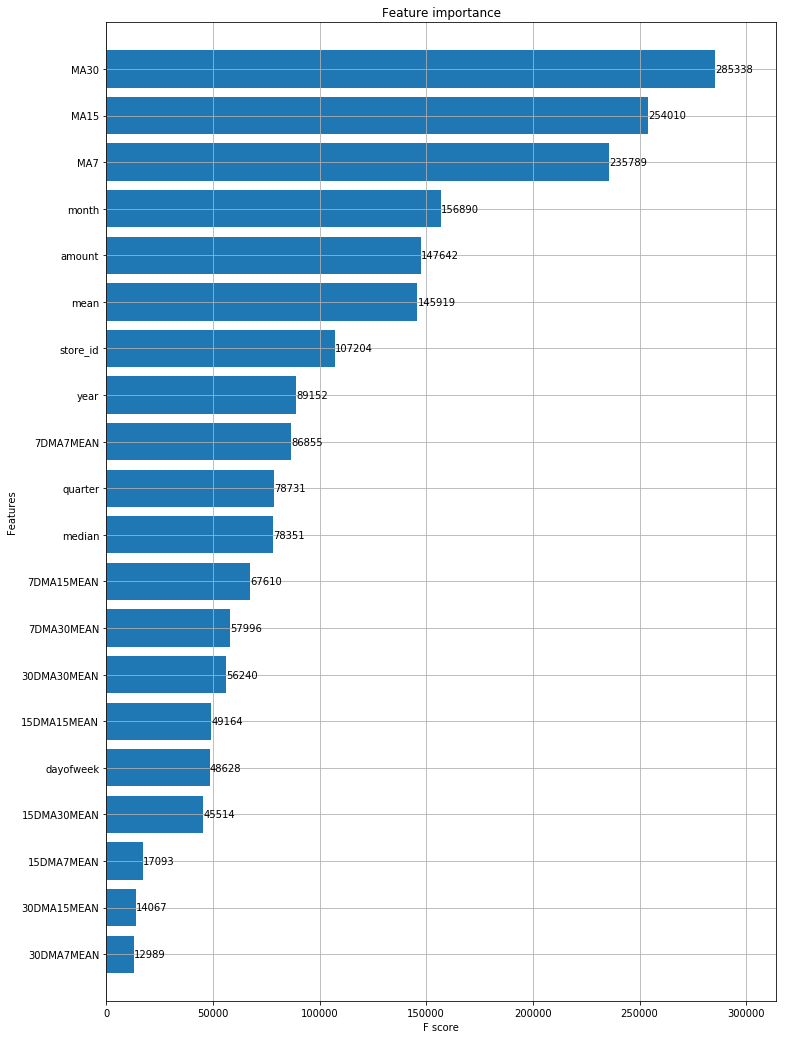

In [16]:
# Feature importance
fig, ax = plt.subplots(figsize=(12, 18))
xgb.plot_importance(model, max_num_features = 50, height = 0.8, ax=ax)
plt.show()

In [17]:
# 결과값을 얻기 위해 데이터프레임 생성
store_list = remains.store_id.unique()
store_list.sort()

r_test = pd.DataFrame(columns=['store_id', 'y', 'transacted_date', 'amount', 'mean', 'median', 
                   'MA7', 'MA15', 'MA30', 
                   '7DMA7MEAN', '7DMA15MEAN' , '7DMA30MEAN',
                   '15DMA7MEAN', '15DMA15MEAN' , '15DMA30MEAN', 
                   '30DMA7MEAN', '30DMA15MEAN' , '30DMA30MEAN',
                   'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'])

for s in store_list:
    # add the latest data of a store
    store_df = remains[remains.store_id == s]
    r_test.loc[len(r_test)] = store_df.iloc[-1]

r_test['transacted_date'] = datetime(2019,3,1)
r_test['transacted_date'] = pd.to_datetime(r_test['transacted_date'])
r_test['dayofweek'] = r_test.transacted_date.dt.dayofweek
r_test['quarter'] = r_test.transacted_date.dt.quarter
r_test['month'] = r_test.transacted_date.dt.month
r_test['year'] = r_test.transacted_date.dt.year
r_test['dayofyear'] = r_test.transacted_date.dt.dayofyear
r_test['dayofmonth'] = r_test.transacted_date.dt.day
r_test['weekofyear'] = r_test.transacted_date.dt.weekofyear

type_dict = {'store_id':int, 'dayofweek':int, 'quarter':int, 'month':int, 'year':int, 
             'dayofyear':int, 'dayofmonth':int, 'weekofyear':int}
r_test = r_test.astype(type_dict)
r_test.head()
    
r_test = r_test.drop(columns=['transacted_date'])
r_test = r_test.sort_values(by='store_id')

# 결과값 예측
y_test = model.predict(xgb.DMatrix(r_test[col]), ntree_limit = model.best_ntree_limit)

In [18]:
submission = pd.read_csv('submission.csv')
submission['amount']  = submission['amount'].astype(float)

In [20]:
submission['amount'] = np.exp(y_test)
# a = pd.Series([i * 0.31 for i in param_list])  # 가게 별 거래 일수 비율을 곱해줌. (결과가 더 나빠짐,,)
submission['amount'] = submission['amount'].apply(lambda x: x * 0.25)

# 제출 파일 생성.
submission.to_csv('results/xgb_model_25.csv', index=False)